<a href="https://colab.research.google.com/github/anandgaurav2011/pyspark-colab/blob/main/Social_Network_As_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 2.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=860ed7c8e8e7bd3f0b95ecc078e0ac327dbceed34d681b2ffadf34b1aa277c3c
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
import pyspark
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.master('local[4]').appName('ml').getOrCreate()

In [ ]:
df = spark.read.csv("/content/drive/MyDrive/sample_data/Social_Network_Ads.csv",header=True,inferSchema=True)

In [ ]:
df.count()

400

In [ ]:
df.show(5)

+--------+------+----+---------------+---------+
| User ID|Gender| Age|EstimatedSalary|Purchased|
+--------+------+----+---------------+---------+
|15624510|  Male|19.0|        19000.0|        0|
|15810944|  Male|35.0|        20000.0|        0|
|15668575|Female|26.0|        43000.0|        0|
|15603246|Female|27.0|        57000.0|        0|
|15804002|  Male|19.0|        76000.0|        0|
+--------+------+----+---------------+---------+
only showing top 5 rows



In [ ]:
df.summary().show()

+-------+-----------------+------+------------------+----------------+------------------+
|summary|          User ID|Gender|               Age| EstimatedSalary|         Purchased|
+-------+-----------------+------+------------------+----------------+------------------+
|  count|              400|   400|               400|             400|               400|
|   mean|  1.56915397575E7|  null|            37.655|         69742.5|            0.3575|
| stddev|71658.32158119006|  null|10.482876597307927|34096.9602824248|0.4798639635968691|
|    min|         15566689|Female|              18.0|         15000.0|                 0|
|    25%|         15625395|  null|              29.0|         43000.0|                 0|
|    50%|         15694288|  null|              37.0|         70000.0|                 0|
|    75%|         15750335|  null|              46.0|         88000.0|                 1|
|    max|         15815236|  Male|              60.0|        150000.0|                 1|
+-------+-

In [ ]:
pdf = df.toPandas()

In [ ]:
df.groupby('Purchased').count().show()

+---------+-----+
|Purchased|count|
+---------+-----+
|        1|  143|
|        0|  257|
+---------+-----+



In [ ]:
pdf['Purchased'].value_counts()

0    257
1    143
Name: Purchased, dtype: int64

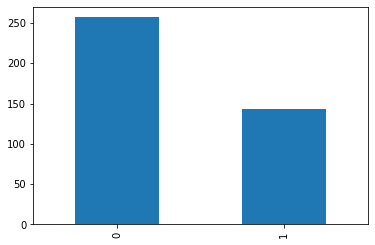

In [ ]:
pdf['Purchased'].value_counts().plot.bar()

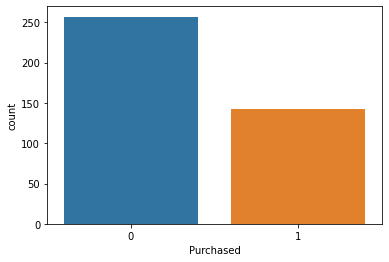

In [ ]:
import seaborn as sns
sns.countplot(x=pdf['Purchased'])

In [ ]:
round(pdf['Purchased'].value_counts()[0]/len(pdf),2)*100

64.0

In [ ]:
round(pdf['Purchased'].value_counts()[1]/len(pdf),2)*100

36.0

In [ ]:
pdf.isnull().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [ ]:
from pyspark.sql.functions import isnull, when, count, col

In [ ]:
# no missing values
df.select([count(when(isnull(c),c)).alias(c) for c in df.columns]).show()

+-------+------+---+---------------+---------+
|User ID|Gender|Age|EstimatedSalary|Purchased|
+-------+------+---+---------------+---------+
|      0|     0|  0|              0|        0|
+-------+------+---+---------------+---------+



In [ ]:
#df = df.withColumn("Gender", when(df.Gender == "Male", "Female").when(df.Gender == 1,0))

In [ ]:
# Assemble the features
required_features = ['Age','EstimatedSalary']

In [ ]:
pdf[required_features]

,Age,EstimatedSalary
0,19.0,19000.0
1,35.0,20000.0
2,26.0,43000.0
3,27.0,57000.0
4,19.0,76000.0
...,...,...
395,46.0,41000.0
396,51.0,23000.0
397,50.0,20000.0
398,36.0,33000.0


In [ ]:
# import the vector assembler clas
from pyspark.ml.feature import VectorAssembler

In [ ]:
# create the object
assembler = VectorAssembler(inputCols=required_features,outputCol='features')

In [ ]:
transformed_data = assembler.transform(df)

In [ ]:
transformed_data.show(5)

+--------+------+----+---------------+---------+--------------+
| User ID|Gender| Age|EstimatedSalary|Purchased|      features|
+--------+------+----+---------------+---------+--------------+
|15624510|  null|19.0|        19000.0|        0|[19.0,19000.0]|
|15810944|  null|35.0|        20000.0|        0|[35.0,20000.0]|
|15668575|  null|26.0|        43000.0|        0|[26.0,43000.0]|
|15603246|  null|27.0|        57000.0|        0|[27.0,57000.0]|
|15804002|  null|19.0|        76000.0|        0|[19.0,76000.0]|
+--------+------+----+---------------+---------+--------------+
only showing top 5 rows



In [ ]:
# split the data in train & test
training_data, test_data = transformed_data.randomSplit([0.75, 0.25], seed = 0)

In [ ]:
training_data.count()

301

In [ ]:
test_data.count()

99

In [ ]:
training_data.groupby('Purchased').count().show()

+---------+-----+
|Purchased|count|
+---------+-----+
|        1|  109|
|        0|  192|
+---------+-----+



In [ ]:
test_data.groupby('Purchased').count().show()

+---------+-----+
|Purchased|count|
+---------+-----+
|        1|   34|
|        0|   65|
+---------+-----+



In [ ]:
training_data.groupby('Purchased').count().select('count').show()

+-----+
|count|
+-----+
|  109|
|  192|
+-----+



In [ ]:
test_data.groupby('Purchased').count().show()

+---------+-----+
|Purchased|count|
+---------+-----+
|        1|   34|
|        0|   65|
+---------+-----+



In [ ]:
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
df = RandomForestClassifier(labelCol='Purchased',featuresCol='features')

In [ ]:
# train the model
model = df.fit(training_data)

In [ ]:
# predictions on unseen data
predictions = model.transform(test_data)

In [ ]:
predictions.show()

+--------+------+----+---------------+---------+---------------+--------------------+--------------------+----------+
| User ID|Gender| Age|EstimatedSalary|Purchased|       features|       rawPrediction|         probability|prediction|
+--------+------+----+---------------+---------+---------------+--------------------+--------------------+----------+
|15566689|  null|35.0|        57000.0|        0| [35.0,57000.0]|[19.8615298962731...|[0.99307649481365...|       0.0|
|15581198|  null|31.0|        74000.0|        0| [31.0,74000.0]|[19.7808847349828...|[0.98904423674914...|       0.0|
|15581282|  null|37.0|        74000.0|        0| [37.0,74000.0]|[17.7475412464456...|[0.88737706232228...|       0.0|
|15584320|  null|37.0|       146000.0|        1|[37.0,146000.0]|[1.55851379447671...|[0.07792568972383...|       1.0|
|15584545|  null|32.0|        86000.0|        0| [32.0,86000.0]|[19.7808847349828...|[0.98904423674914...|       0.0|
|15586757|  null|39.0|       134000.0|        1|[39.0,13

In [ ]:
pdf1 = predictions.select('prediction').toPandas()

In [ ]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

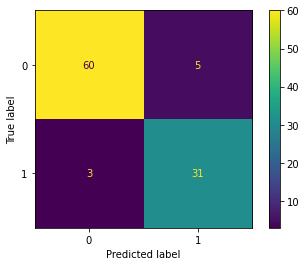

In [ ]:
pred = predictions.select('prediction').toPandas()
actual = test_data.select('Purchased').toPandas()

ConfusionMatrixDisplay.from_predictions(actual, pred)

In [ ]:
accuracy_score(actual, pred)

0.9191919191919192

In [ ]:
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94        65
           1       0.86      0.91      0.89        34

    accuracy                           0.92        99
   macro avg       0.91      0.92      0.91        99
weighted avg       0.92      0.92      0.92        99



In [ ]:
# import the evaluation class
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
eval = MulticlassClassificationEvaluator(labelCol='Purchased',metricName='accuracy')

In [ ]:
print("Accuracy:", eval.evaluate(predictions))

Accuracy: 0.9191919191919192
